# ODNN

## Loading Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
import torch
import torch.nn as nn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from torchvision import datasets,transforms
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn import metrics

## Data Loading

In [2]:
transform = transforms.ToTensor()
trainset  = datasets.CIFAR10('root', download=True, train=True, transform=transform)
valset    = datasets.CIFAR10('root', download=True, train=False, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cpu device


In [4]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=28, shuffle=True)

**Dataloaders** are used to store data in mini-batches with *(batch,x,y)* as tuple objects

In [5]:
dataiter=iter(trainloader)
images,labels=dataiter.next()
print(images.shape)
print(labels.shape)

torch.Size([128, 3, 32, 32])
torch.Size([128])


*    ***Images size***: 128(batch size), 3(no of channels-RGB), 32*32(Image dimensions)
*    ***Labels size*** : 128(batch size)

In [6]:
n=images.shape[1]*images.shape[2]*images.shape[3]
m=len(trainset)
m_test=len(valset)

## Model

In [7]:
import torch.nn.functional as F
class ConvBlock(nn.Module):
    '''Pre-activation version of the BasicBlock.'''

    def __init__(self, in_planes, planes, stride=1):
        super(ConvBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=True)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=True)

    def forward(self, x):
        out = self.bn1(x)
        out = self.conv1(F.relu(out))
        out = self.bn2(out)
        out = self.conv2(F.relu(out))
        return out

class ConvNet_CIFAR(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ConvNet_CIFAR, self).__init__()
        self.in_planes = 16

        self.conv0 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=True)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.last_act = nn.Sequential(nn.BatchNorm2d(64), nn.ReLU(inplace=True))
        self.linear = nn.Linear(64, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv0(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.last_act(out)
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ConvNet20():
    return ConvNet_CIFAR(ConvBlock, [3,3,3], 10)

## Hyper Parameter Setting

In [8]:
def load_model():
    return ConvNet20().to(device)
print(load_model())

ConvNet_CIFAR(
  (conv0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (layer1): Sequential(
    (0): ConvBlock(
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): ConvBlock(
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (2): ConvBlock(
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(16

**Hyperparameters**<br>


*   ***Lembda*** : regularisation constant (Used to increase orthogonality)
*   ***Optimizer*** : Stochastic Gradient Descent(SGD)
*   ***Learning rate scheduler*** : vary learning rate over epochs





## Loss Function

In [9]:
def loss_fn(model,output,y):
    l=nn.CrossEntropyLoss()
    extra_norm=0
    for m in model.modules():
        if isinstance(m,nn.Linear) or isinstance(m,nn.Conv2d):
            tmp=m.weight.view(m.weight.data.size(0), -1) 
            """Converts 4-d filter tensor to 2-d tensor which represents 
            linear operation of convolution and does not effect 2-d linear matrix"""

            s1,s2=tmp.shape # For unequal matrices semi orthogonal condition is imposed

            if s1<s2:
                extra_norm+=torch.norm(torch.mm(tmp,tmp.t())-torch.eye(s1).to(device),p='fro')
            else:
                extra_norm+=torch.norm(torch.mm(tmp.t(),tmp)-torch.eye(s2).to(device),p='fro')

    loss=l(output,y)+lembda/2*extra_norm #norm loss is added to original loss
    return loss

**Loss function** : Used to introduce Orthogonality constraints in network.<br>
**Total Loss** = Normal Loss + Extra Norm Loss<br>
**Normal Loss**= Cross Entropy Loss(For Classification) or MSE (Regression)<br>
**Extra Norm Loss** = lemda*|| Wt.W-I || for orthogonality

## Training Module

Mini batch gradient descent is performed

In [10]:
def train(data,model,optimizer):
    running_loss,running_accuracy=0,0
    for batch,(x,y) in enumerate(data):
        x, y = x.to(device), y.to(device)
        output=model(x.float())
        loss=loss_fn(model,output,y) 

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        with torch.no_grad(): # Calculating Training Accuracy
            running_loss+=loss.item()*(x.shape[0])
            running_accuracy+=torch.sum(y==torch.argmax(output,dim=1)).item()

    return running_loss,running_accuracy

## Validation Module

In [11]:
def validate(model,data):
    running_accuracy=0
    for b,(x,y) in enumerate(data):
        x, y =x.to(device), y.to(device)
        output=model(x.float())
        running_accuracy+=torch.sum(y==torch.argmax(output,dim=1)).item()
    return running_accuracy

## Model Training

In [12]:
loss_curves=[] #For Loss curve data storage
train_curves=[] #For Accuracy curve data storage
val_curves=[] #For validation accuracy curve data storage
models=[] #for model storage

In [13]:
lembdas=[0.,0.01,0.05,0.1] #Set Values for lambda to be tested
for lembda in lembdas:

    model=load_model() #Loading Model
    optimizer=torch.optim.SGD(model.parameters(),lr=0.01) #Setting Model Parameters
    lr_scheduler=torch.optim.lr_scheduler.StepLR(optimizer,2,0.94406)
    epochs = 100
    loss_dnn=np.zeros(0)
    val_dnn=np.zeros(0)
    accuracy_dnn=np.zeros(0)

    print("Training Started For Lambda =",lembda,"\n--------------------------")

    for t in range(epochs):
        epoch_loss,epoch_accuracy=train(trainloader, model, optimizer) #Training performed
        epoch_loss/=m
        epoch_accuracy/=m

        with torch.no_grad():
            val_dnn=np.append(val_dnn,validate(model,valloader)/m_test) #Validation performed
            loss_dnn=np.append(loss_dnn,epoch_loss)
            accuracy_dnn=np.append(accuracy_dnn,epoch_accuracy)
            lr_scheduler.step() #Learning rate modified

        print(f"\tEpoch {t+1}")
        print("\tLoss:",epoch_loss)
        print("\tTrain Accuracy",epoch_accuracy,"Validation Accuracy",val_dnn[-1])

    loss_curves.append(loss_dnn)
    val_curves.append(val_dnn)
    train_curves.append(accuracy_dnn)
    models.append(model)

print("Done!")

Training Started For Lambda = 0.0 
--------------------------
	Epoch 1
	Loss: 1.9848776702499389
	Train Accuracy 0.24894 Validation Accuracy 0.3206
Done!


## Analysis

Text(0.5, 1.0, 'Loss Curve Comparison for different λ')

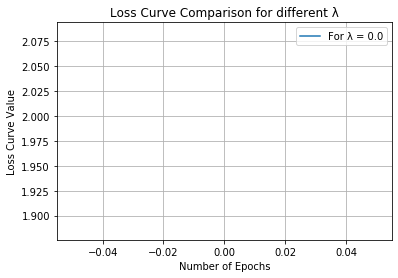

In [14]:
for i in range(len(lembdas)):
    my_label="For \u03BB = "+str(lembdas[i])
    plt.plot(loss_curves[i],label=my_label)
plt.legend()
plt.grid()
plt.ylabel('Loss Curve Value')
plt.xlabel('Number of Epochs')
plt.title('Loss Curve Comparison for different \u03BB')

Text(0.5, 1.0, 'Training Accuracy Comparison for different λ')

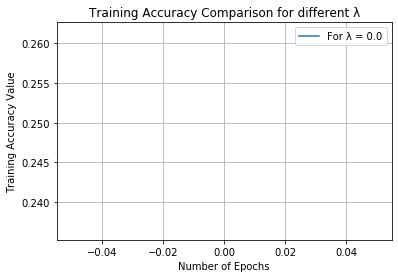

In [15]:
for i in range(len(lembdas)):
    my_label="For \u03BB = "+str(lembdas[i])
    plt.plot(train_curves[i],label=my_label)
plt.legend()
plt.grid()
plt.ylabel('Training Accuracy Value')
plt.xlabel('Number of Epochs')
plt.title('Training Accuracy Comparison for different \u03BB')

Text(0.5, 1.0, 'Validation Accuracy Comparison for different λ')

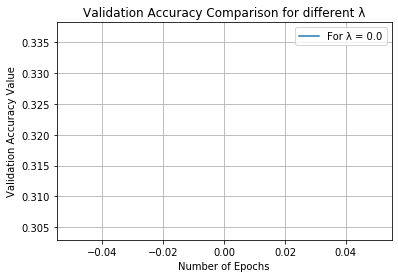

In [16]:
for i in range(len(lembdas)):
    my_label="For \u03BB = "+str(lembdas[i])
    plt.plot(val_curves[i],label=my_label)
plt.legend()
plt.grid()
plt.ylabel('Validation Accuracy Value')
plt.xlabel('Number of Epochs')
plt.title('Validation Accuracy Comparison for different \u03BB')

## Confusion Matrix Print

In [17]:
def generate_matrix(model,data):
    y_real=torch.zeros(0)
    y_pred=torch.zeros(0)
    y_proba=torch.zeros(0)
    for b,(x,y) in enumerate(data):
        x, y =x.to(device), y.to(device)
        output=model(x.float())
        y_real=torch.cat((y_real,y.cpu()),0)
        y_pred=torch.cat((y_pred,torch.argmax(output,dim=1).cpu()),0)
        y_proba=torch.cat((y_proba,output.cpu()),0)
    return y_real,y_pred,y_proba

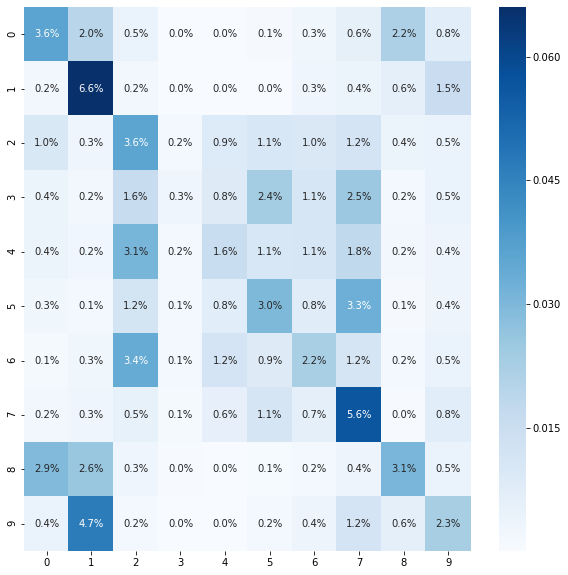

In [18]:
with torch.no_grad():
    for model in models:
        y_true,y_pred,_=generate_matrix(model,valloader)
        cf_matrix=confusion_matrix(y_true,y_pred)
        plt.figure(figsize=(10,10))
        sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.1%', cmap='Blues')

## ROC-AUC

In [21]:
def plot_roc(model,data):
    plt.figure()
    y_true,_,y_proba=generate_matrix(model,data)
    for i in range(10):
        fpr, tpr, thresholds = metrics.roc_curve(y_true, y_proba[:,i], pos_label=i)
        auc=metrics.auc(fpr,tpr)
        auc=float("{:.2f}".format(auc))
        label="class "+str(i)+" AUC Score :"+str(auc);
        plt.plot(fpr,tpr,label=label)
    x=np.linspace(0,1,100)
    plt.plot(x,x,'k--')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC Curve with AUC")
    plt.grid()
    plt.show()

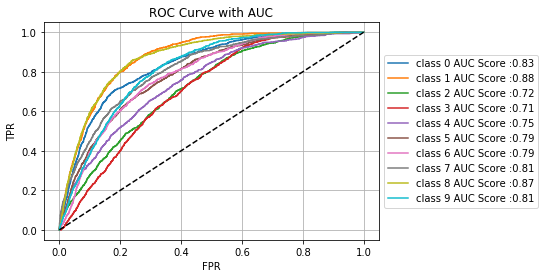

In [22]:
with torch.no_grad():
    for model in models:
        plot_roc(model,valloader)